In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
cd "/content/gdrive/My Drive/Projects /RL_Driving/ld8/Ultra-Fast-Lane-Detection"

/content/gdrive/My Drive/Projects /RL_Driving/ld8/Ultra-Fast-Lane-Detection


In [ ]:
import torch,pdb
import torchvision
import torch.nn.modules
import numpy as np
import os, datetime
from torchvision import models
from torchsummary import summary
from PIL import Image
import torchvision.transforms as transforms
import os, json, torch, scipy
import platform
from scipy import special
import matplotlib.pyplot as plt
import matplotlib.image as img
import cv2

# Model Arch

In [ ]:
class vgg16bn(torch.nn.Module):
    def __init__(self,pretrained = False):
        super(vgg16bn,self).__init__()
        model = list(torchvision.models.vgg16_bn(pretrained=pretrained).features.children())
        model = model[:33]+model[34:43]
        self.model = torch.nn.Sequential(*model)
        
    def forward(self,x):
        return self.model(x)
class resnet(torch.nn.Module):
    def __init__(self,layers,pretrained = False):
        super(resnet,self).__init__()
        if layers == '18':
            model = torchvision.models.resnet18(pretrained=pretrained)
        elif layers == '34':
            model = torchvision.models.resnet34(pretrained=pretrained)
        elif layers == '50':
            model = torchvision.models.resnet50(pretrained=pretrained)
        elif layers == '101':
            model = torchvision.models.resnet101(pretrained=pretrained)
        elif layers == '152':
            model = torchvision.models.resnet152(pretrained=pretrained)
        elif layers == '50next':
            model = torchvision.models.resnext50_32x4d(pretrained=pretrained)
        elif layers == '101next':
            model = torchvision.models.resnext101_32x8d(pretrained=pretrained)
        elif layers == '50wide':
            model = torchvision.models.wide_resnet50_2(pretrained=pretrained)
        elif layers == '101wide':
            model = torchvision.models.wide_resnet101_2(pretrained=pretrained)
        else:
            raise NotImplementedError
        
        self.conv1 = model.conv1
        self.bn1 = model.bn1
        self.relu = model.relu
        self.maxpool = model.maxpool
        self.layer1 = model.layer1
        self.layer2 = model.layer2
        self.layer3 = model.layer3
        self.layer4 = model.layer4

    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x2 = self.layer2(x)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        return x2,x3,x4

In [ ]:
class conv_bn_relu(torch.nn.Module):
    def __init__(self,in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1,bias=False):
        super(conv_bn_relu,self).__init__()
        self.conv = torch.nn.Conv2d(in_channels,out_channels, kernel_size, 
            stride = stride, padding = padding, dilation = dilation,bias = bias)
        self.bn = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.ReLU()

    def forward(self,x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x
class parsingNet(torch.nn.Module):
    def __init__(self, size=(288, 800), pretrained=True, backbone='50', cls_dim=(37, 10, 4), use_aux=False):
        super(parsingNet, self).__init__()

        self.size = size
        self.w = size[0]
        self.h = size[1]
        self.cls_dim = cls_dim # (num_gridding, num_cls_per_lane, num_of_lanes)
        # num_cls_per_lane is the number of row anchors
        self.use_aux = use_aux
        self.total_dim = np.prod(cls_dim)

        # input : nchw,
        # output: (w+1) * sample_rows * 4 
        self.model = resnet(backbone, pretrained=pretrained)

        if self.use_aux:
            self.aux_header2 = torch.nn.Sequential(
                conv_bn_relu(128, 128, kernel_size=3, stride=1, padding=1) if backbone in ['34','18'] else conv_bn_relu(512, 128, kernel_size=3, stride=1, padding=1),
                conv_bn_relu(128,128,3,padding=1),
                conv_bn_relu(128,128,3,padding=1),
                conv_bn_relu(128,128,3,padding=1),
            )
            self.aux_header3 = torch.nn.Sequential(
                conv_bn_relu(256, 128, kernel_size=3, stride=1, padding=1) if backbone in ['34','18'] else conv_bn_relu(1024, 128, kernel_size=3, stride=1, padding=1),
                conv_bn_relu(128,128,3,padding=1),
                conv_bn_relu(128,128,3,padding=1),
            )
            self.aux_header4 = torch.nn.Sequential(
                conv_bn_relu(512, 128, kernel_size=3, stride=1, padding=1) if backbone in ['34','18'] else conv_bn_relu(2048, 128, kernel_size=3, stride=1, padding=1),
                conv_bn_relu(128,128,3,padding=1),
            )
            self.aux_combine = torch.nn.Sequential(
                conv_bn_relu(384, 256, 3,padding=2,dilation=2),
                conv_bn_relu(256, 128, 3,padding=2,dilation=2),
                conv_bn_relu(128, 128, 3,padding=2,dilation=2),
                conv_bn_relu(128, 128, 3,padding=4,dilation=4),
                torch.nn.Conv2d(128, cls_dim[-1] + 1,1)
                # output : n, num_of_lanes+1, h, w
            )
            initialize_weights(self.aux_header2,self.aux_header3,self.aux_header4,self.aux_combine)

        self.cls = torch.nn.Sequential(
            torch.nn.Linear(1800, 2048),
            torch.nn.ReLU(),
            torch.nn.Linear(2048, self.total_dim),
        )

        self.pool = torch.nn.Conv2d(512,8,1) if backbone in ['34','18'] else torch.nn.Conv2d(2048,8,1)
        # 1/32,2048 channel
        # 288,800 -> 9,40,2048
        # (w+1) * sample_rows * 4
        # 37 * 10 * 4
        initialize_weights(self.cls)

    def forward(self, x):
        # n c h w - > n 2048 sh sw
        # -> n 2048
        x2,x3,fea = self.model(x)
        if self.use_aux:
            x2 = self.aux_header2(x2)
            x3 = self.aux_header3(x3)
            x3 = torch.nn.functional.interpolate(x3,scale_factor = 2,mode='bilinear')
            x4 = self.aux_header4(fea)
            x4 = torch.nn.functional.interpolate(x4,scale_factor = 4,mode='bilinear')
            aux_seg = torch.cat([x2,x3,x4],dim=1)
            aux_seg = self.aux_combine(aux_seg)
        else:
            aux_seg = None

        fea = self.pool(fea).view(-1, 1800)

        group_cls = self.cls(fea).view(-1, *self.cls_dim)

        if self.use_aux:
            return group_cls, aux_seg

        return group_cls


def initialize_weights(*models):
    for model in models:
        real_init_weights(model)
def real_init_weights(m):

    if isinstance(m, list):
        for mini_m in m:
            real_init_weights(mini_m)
    else:
        if isinstance(m, torch.nn.Conv2d):    
            torch.nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                torch.nn.init.constant_(m.bias, 0)
        elif isinstance(m, torch.nn.Linear):
            m.weight.data.normal_(0.0, std=0.01)
        elif isinstance(m, torch.nn.BatchNorm2d):
            torch.nn.init.constant_(m.weight, 1)
            torch.nn.init.constant_(m.bias, 0)
        elif isinstance(m,torch.nn.Module):
            for mini_m in m.children():
                real_init_weights(mini_m)
        else:
            print('unkonwn module', m)

#Loading pretrained weights

In [ ]:
'''

# DATA
dataset='Tusimple'
data_root = None

# TRAIN
epoch = 100
batch_size = 32
optimizer = 'Adam'    #['SGD','Adam']
# learning_rate = 0.1
learning_rate = 4e-4
weight_decay = 1e-4
momentum = 0.9

scheduler = 'cos'     #['multi', 'cos']
# steps = [50,75]
gamma  = 0.1
warmup = 'linear'
warmup_iters = 100

# NETWORK
backbone_i = '18'

use_aux = True

# LOSS
sim_loss_w = 1.0
shp_loss_w = 0.0

# EXP
note = ''

log_path = None

# FINETUNE or RESUME MODEL PATH
finetune = None
resume = None

# TEST
test_model = None
test_work_dir = None

num_lanes = 4

'''
# DATA
dataset='CULane'
data_root = None

# TRAIN
epoch = 50
batch_size = 32
optimizer = 'SGD'  #['SGD','Adam']
learning_rate = 0.1
weight_decay = 1e-4
momentum = 0.9

scheduler = 'multi' #['multi', 'cos']
steps = [25,38]
gamma  = 0.1
warmup = 'linear'
warmup_iters = 695

# NETWORK
use_aux = True
griding_num = 200
backbone = '18'

# LOSS
sim_loss_w = 0.0
shp_loss_w = 0.0

# EXP
note = ''

log_path = None

# FINETUNE or RESUME MODEL PATH
finetune = None
resume = None

# TEST
test_model = None
test_work_dir = None

num_lanes = 4

In [ ]:
backbone_i = '18'

In [ ]:
#Tusimple
#cls_num_per_lane = 56
#culane
cls_num_per_lane = 18
#num_lanes = 4
#griding_num = 200

In [ ]:
net = parsingNet(pretrained = True, backbone=backbone_i,cls_dim = (griding_num+1,cls_num_per_lane, num_lanes),use_aux=False)

In [ ]:
ls

1.jpg  3.jpg    caffe/         lines.txt  res.txt  tusimple_18.pth
2.jpg  520.jpg  culane_18.pth  res/       s.jpg    Ultra-Fast-Lane-Detection/


In [ ]:
state_dict = torch.load("culane_18.pth", map_location = 'cpu')['model']
compatible_state_dict = {}



In [ ]:
for k, v in state_dict.items():
  if 'module.' in k:
    compatible_state_dict[k[7:]] = v
  else:
    compatible_state_dict[k] = v

In [ ]:
net.load_state_dict(compatible_state_dict, strict = False)

<All keys matched successfully>

# Test

In [ ]:
#print(net)
#summary(net,(3,288,800)) 

names=["hello"]
output_path="res/"
'''
#row anchor for tu simple 
row_anchor = [ 64,  68,  72,  76,  80,  84,  88,  92,  96, 100, 104, 108, 112,
            116, 120, 124, 128, 132, 136, 140, 144, 148, 152, 156, 160, 164,
            168, 172, 176, 180, 184, 188, 192, 196, 200, 204, 208, 212, 216,
            220, 224, 228, 232, 236, 240, 244, 248, 252, 256, 260, 264, 268,
            272, 276, 280, 284]
'''
#culane
row_anchor = [121, 131, 141, 150, 160, 170, 180, 189, 199, 209, 219, 228, 238, 248, 258, 267, 277, 287]

In [ ]:
def test(file_name,line_save_path,griding_num):
  x=Image.open(file_name)
  img_w=x.size[0]
  img_h=x.size[1]
  img_transforms = transforms.Compose([
          transforms.Resize((288, 800)),
          transforms.ToTensor(),
          transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
      ])
  transformed_x = img_transforms(x)
  x_final=transformed_x.unsqueeze(0)
  out=net(x_final)
  vis = cv2.imread(file_name)
  final_img=generate_lines(out, x_final[0,0].shape, line_save_path, griding_num,vis, img_w, img_h ,localization_type='rel', flip_updown=True)
  plt.imshow(final_img)
  return final_img

In [ ]:
def generate_lines(out, shape, line_save_path, griding_num,vis , img_w, img_h,localization_type='abs', flip_updown=True):
    col_sample = np.linspace(0, shape[1] - 1, griding_num)
    col_sample_w = col_sample[1] - col_sample[0]

    for j in range(out.shape[0]):
        out_j = out[j].data.cpu().numpy()
        if flip_updown:
            out_j = out_j[:, ::-1, :]
        if localization_type == 'abs':
            #print("abs localisation type")
            out_j = np.argmax(out_j, axis=0)
            out_j[out_j == griding_num] = -1
            out_j = out_j + 1
        elif localization_type == 'rel':
            #print("rel localisation type")
            prob = scipy.special.softmax(out_j[:-1, :, :], axis=0)
            idx = np.arange(griding_num) + 1
            idx = idx.reshape(-1, 1, 1)
            loc = np.sum(prob * idx, axis=0)
            out_j = np.argmax(out_j, axis=0)
            loc[out_j == griding_num] = 0
            out_j = loc
        else:
            raise NotImplementedError
        name = names[j]

        #line_save_path = os.path.join(output_path, name[:-3] + 'lines.txt')
        #save_dir, _ = os.path.split(line_save_path)
        #if not os.path.exists(save_dir):
            #os.makedirs(save_dir)
        with open(line_save_path, 'w') as fp:
            for i in range(out_j.shape[1]):
                if np.sum(out_j[:, i] != 0) > 2:
                    for k in range(out_j.shape[0]):
                        if out_j[k, i] > 0:
                          ppp = (int(out_j[k, i] * col_sample_w * img_w / 800) - 1, int(img_h * (row_anchor[cls_num_per_lane-1-k]/288)) - 1 )
                          vis=cv2.circle(vis,ppp,5,(255,0,0),-1)
                          #print("plotting circle")
    return vis           

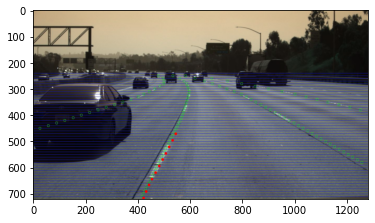

In [ ]:
img=test("3.jpg","res.txt",griding_num)

In [ ]:
ls

1.jpg  3.jpg    caffe/         lines.txt  res.txt  tusimple_18.pth
2.jpg  520.jpg  culane_18.pth  res/       s.jpg


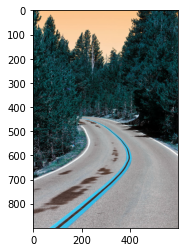

In [ ]:
img=test("1.jpg","res.txt",griding_num)

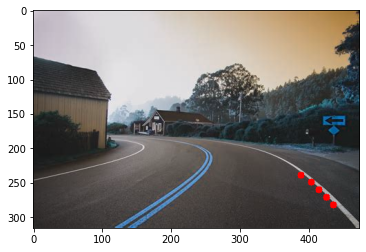

In [ ]:
img=test("2.jpg","res.txt",griding_num)

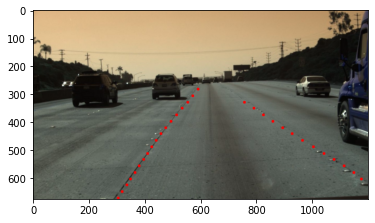

In [ ]:
img=test("520.jpg","res.txt",griding_num)

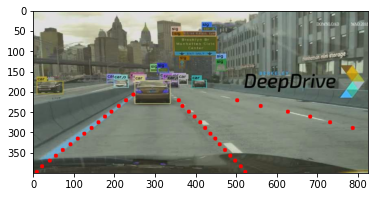

In [ ]:
img=test("s.jpg","res.txt",griding_num)

In [ ]:
cd '/content/gdrive/My Drive/Projects /RL_Driving/ld8/video files'

/content/gdrive/My Drive/Projects /RL_Driving/ld8/video files


In [ ]:
ls

520.jpg  sm.mp4      t3.mp4           test_cul.mp4  tst.mp4
res.txt  sucess.mp4  test_culane.mp4  test.mkv


In [ ]:
import os
import cv2

output="t3_full_results.mp4"
# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Be sure to use lower case

#frame = cv2.imread("520.jpg")
height, width, channels = img.shape
out = cv2.VideoWriter(output, fourcc, 20.0, (width, height))



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


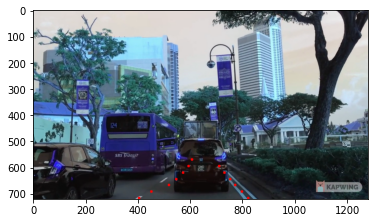

In [ ]:
# Opens the Video file
i=0;
#video_name="y.avi"
cap= cv2.VideoCapture('t3.mp4')
#video = cv2.VideoWriter(video_name, 0, 1, (720, 1280)) 
while(cap.isOpened()):
    i=i+1;
    print(i);
    ret, frame = cap.read()
    if ret == False:
        break
    cv2.imwrite('img'+'.jpg',frame)
    img=test("img.jpg","res.txt",griding_num)
    out.write(img)
    os.remove("img.jpg")
    #if(i==200):
    #  break
out.release()
    
 